# Neural Correlates of Volitional Grasp Control

## Pre-processing

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import mne

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from scipy.signal import find_peaks, spectrogram
from scipy.signal import butter, lfilter
from scipy.signal import welch

In [ ]:
os.getcwd()
data_path = r"E:\University\IIT Gandhinagar\EEG-Open-Close\EEG-based-BCI-for-grasp-prediction\Data\Raw Data"
os.chdir(data_path)
os.getcwd()

'E:\\University\\IIT Gandhinagar\\EEG-Open-Close\\EEG-based-BCI-for-grasp-prediction\\Data\\Raw Data'

In [93]:
nChannels = 64
sf = 1000

In [8]:
eeg_files = glob.glob("*.xdf")
print(eeg_files)

['FP01.xdf', 'FP02.xdf', 'FP03.xdf', 'FP05.xdf', 'FP06.xdf', 'FP07.xdf', 'FP08.xdf', 'FP09.xdf', 'FP10.xdf', 'FP11.xdf', 'FP12.xdf', 'FP13.xdf', 'P01.xdf', 'P02.xdf', 'P03.xdf']


In [56]:
import pyxdf

file_path = os.path.join(data_path, eeg_files[0])
data, header = pyxdf.load_xdf(file_path)

data[0]["time_series"].shape

(1906624, 64)

In [57]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-64_1.0")
mne_info = mne.create_info(montage.ch_names, sfreq=sf, ch_types="eeg")
raw_mne = mne.io.RawArray(data[0]["time_series"].T, mne_info, verbose=True)
raw_mne.set_montage(montage)
raw_mne

Creating RawArray with float64 data, n_channels=64, n_times=1906624
    Range : 0 ... 1906623 =      0.000 ...  1906.623 secs
Ready.


<RawArray | 64 x 1906624 (1906.6 s), ~931.0 MiB, data loaded>

(64, 1906624)


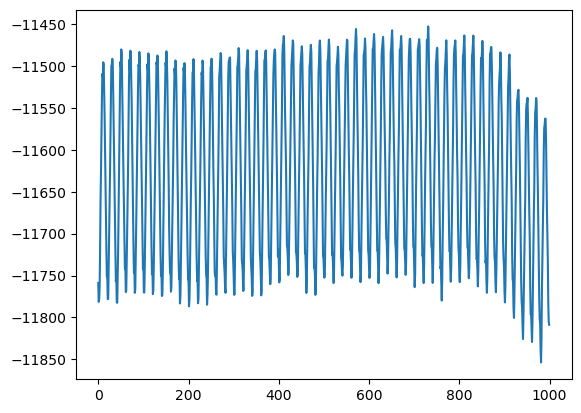

In [67]:
raw_np = raw_mne.get_data()
print(raw_np.shape)
plt.plot(raw_np[0, :1000])
plt.show()

In [ ]:
raw_mne.filter(l_freq=0.1, h_freq=45.0)
raw_mne.plot_psd(fmin=0, fmax=50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


<RawArray | 64 x 1906624 (1906.6 s), ~931.0 MiB, data loaded>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\shiva\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


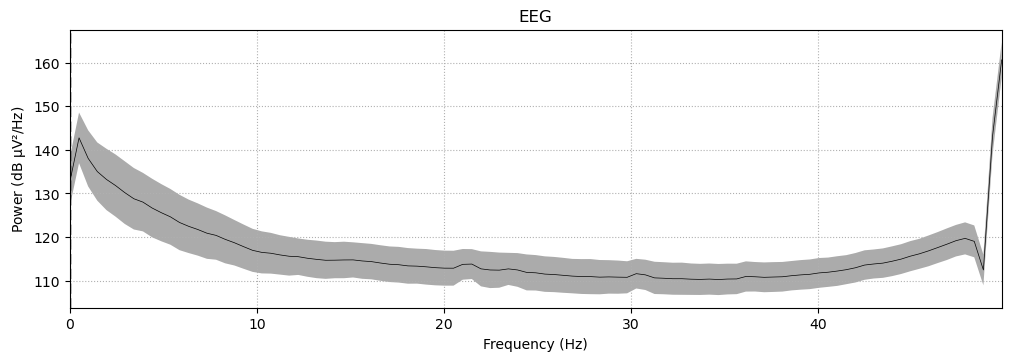

In [49]:
raw_mne.plot_psd(fmin=0, fmax=50, average=True)
plt.show()

Filtering raw data in 1 contiguous segment


Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.0s



Power Spectral Density (PSD) after filtering:
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\shiva\AppData\Roaming\Python\Python312\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


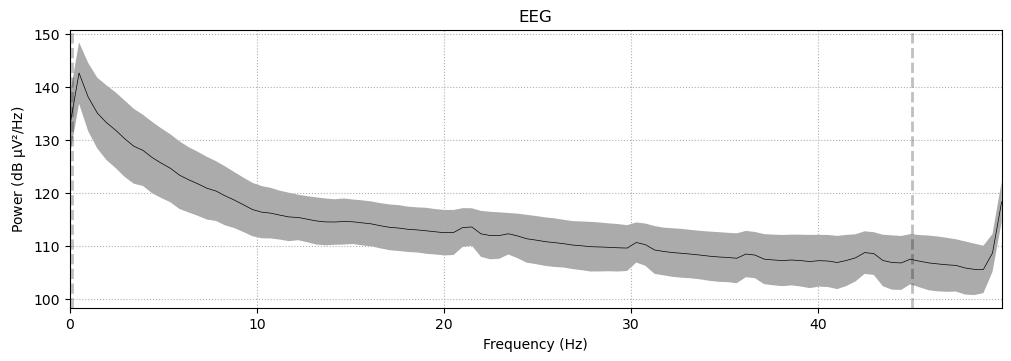

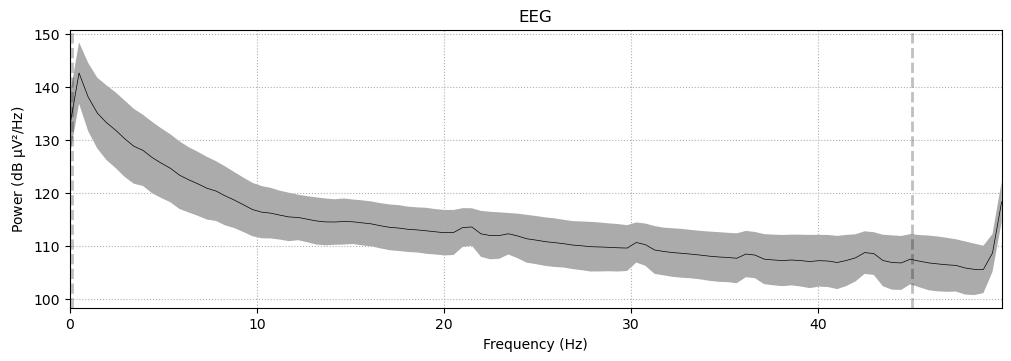

In [ ]:
# a) Bandpass filter (remove slow drifts and high freq noise)
raw_mne.filter(l_freq=0.1, h_freq=45.0)

# b) Notch filter for powerline noise (Choose 50 or 60 Hz depending on country)
# Example for 50 Hz (India/Europe), or switch to 60 for USA
raw_mne.notch_filter(freqs=[50, 100], picks='eeg')  # Also removing 1st harmonic

# -----------------------------------
# 5. Plot PSD after filtering
# -----------------------------------
print("\nPower Spectral Density (PSD) after filtering:")
raw_mne.plot_psd(fmin=0, fmax=50, average=True)
plt.show()


In [53]:
raw_data_numpy = raw_mne.get_data()
raw_data_numpy.shape

(64, 1906624)

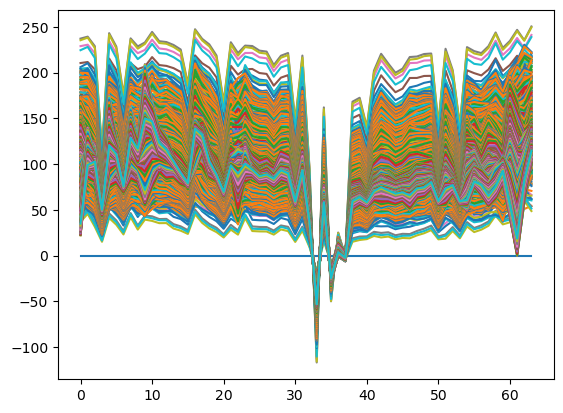

In [ ]:
plt.plot(raw_data_numpy[:, :1000])
plt.show()

In [68]:
clean_data_path = r"E:\University\IIT Gandhinagar\EEG-Open-Close\EEG-based-BCI-for-grasp-prediction\Data\Cleaned\Clean_Data.csv"
clean_data = pd.read_csv(clean_data_path)
clean_data.head()

,-100,-96,-92,-88,-84,-80,-76,-72,-68,-64,...,1984,1988,1992,1996,handPos,Hand,Action,Subject,Channel,Trial
0,0.992095,1.045134,0.821468,0.452555,0.167359,0.094921,0.189011,0.329643,0.452000,0.571202,...,0.901282,1.205751,1.477981,1.604695,palmDown,Right,Open,P01,E1,1
1,2.327051,1.829087,1.126410,0.539903,0.254767,0.220154,0.275524,0.326122,0.358070,0.339999,...,1.157870,1.758465,2.152331,2.008305,palmDown,Right,Open,P01,E2,1
2,1.469934,0.977102,0.371654,-0.247481,-0.769376,-1.051254,-0.927896,-0.341758,0.494546,1.133734,...,3.734554,2.259370,0.694383,-0.241412,palmDown,Right,Open,P01,E3,1
3,1.174265,0.275177,-0.301046,-0.423238,-0.229120,0.078764,0.419357,0.789833,1.066523,0.971994,...,7.144750,6.395225,5.569899,4.741736,palmDown,Right,Open,P01,E4,1
4,2.255072,1.371588,0.617765,0.299977,0.366954,0.458520,0.244992,-0.272633,-0.790045,-1.003268,...,-4.013077,-3.801898,-3.589362,-3.451835,palmDown,Right,Open,P01,E5,1


In [88]:
def get_trial_dat(Subject, Hand, handPos, Trial, Action):
    return {"eeg": clean_data[
        (clean_data["Subject"] == Subject) & 
        (clean_data["Hand"] == Hand) & 
        (clean_data["handPos"] == handPos) & 
        (clean_data["Trial"] == Trial) & 
        (clean_data["Action"] == Action)].to_numpy()[:, :-6], 
        "info": {"Subject": Subject, "Hand": Hand, "handPos": handPos, "Trial": Trial, "Action": Action},
        "timestamp": clean_data.columns[:-6]
        }
trial_data = get_trial_dat("P01", "Right", "palmDown", 1, "Open")
trial_data, trial_data["eeg"].shape, trial_data["info"], trial_data["timestamp"]


({'eeg': array([[0.9920945204696148, 1.045134378007912, 0.8214677660554971, ...,
          1.2057505427689212, 1.477980825616375, 1.6046950666707405],
         [2.327050809612896, 1.829086842699151, 1.126409840645979, ...,
          1.7584649227696092, 2.152330770950941, 2.008304642272821],
         [1.4699339969702336, 0.9771020535760232, 0.3716541723619345, ...,
          2.259369686700761, 0.6943830062091245, -0.2414115005520491],
         ...,
         [0.5101147351016099, 1.4457160520840044, 1.0969019957114845, ...,
          3.559497880352188, 3.888155569129985, 3.0774691352842387],
         [-1.3104580666460344, -0.3677528302642608, 0.1139096302526409,
          ..., -2.1529290073152003, -0.8266372365244867,
          -0.4290388281710535],
         [-0.9289799951740618, -0.4920836830183343, -0.5140364581913314,
          ..., -2.839395338960933, -1.4924632526124213,
          -0.7062581326008633]], dtype=object),
  'info': {'Subject': 'P01',
   'Hand': 'Right',
   'handPos': 'pa

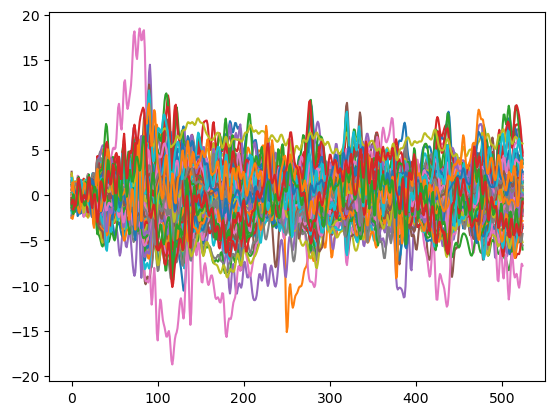

In [ ]:
for ch in range(nChannels):
    plt.plot(trial_data["eeg"][ch, :])
plt.show()

TypeError: Image data of dtype object cannot be converted to float

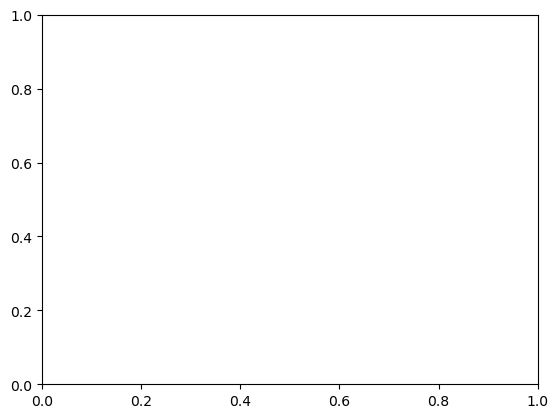

In [100]:
s, t, Sxx = spectrogram(trial_data["eeg"][0, :], fs=sf, nperseg=256, noverlap=128)
plt.pcolormesh(t, s, Sxx)